# WTH is YOLO?
- Tashrique Ahmed
- Miton Vento
- Henok Misgina Fisseha
---

# Introduction

```tl;dr: Very interesting algorithm that creates bounding boxes and labels around images/videos. Very very very very fast!```

You Only Look Once (YOLO) is a state-of-the-art, real-time object detection algorithm introduced in 2015 by [Joseph Redmon](https://arxiv.org/search/cs?searchtype=author&query=Redmon%2C+J), [Santosh Divvala](https://arxiv.org/search/cs?searchtype=author&query=Divvala%2C+S), [Ross Girshick](https://arxiv.org/search/cs?searchtype=author&query=Girshick%2C+R), and [Ali Farhadi](https://arxiv.org/search/cs?searchtype=author&query=Farhadi%2C+A) in their famous research paper [“You Only Look Once: Unified, Real-Time Object Detection”](https://arxiv.org/abs/1506.02640). 

YOLO fundamentally transforms the field of object detection by treating the identification of objects in images as a single regression problem.

Unlike traditional methods that scan images in parts, YOLO examines the entire image in __one evaluation__, predicting bounding boxes and class probabilities simultaneously. This streamlined approach not only speeds up the detection process, allowing it to run in real-time at impressive speeds, but also simplifies the model architecture, enabling end-to-end optimization directly on detection performance.

![Introduction](./img/1.png)
<!-- ![Why Fast](./img/2.png) -->
---

# How does YOLO do its thing?

`` YOLO algorithm (1) divides into S×S grid, (2) predicts B bounding boxes and scores for each cell, (3) calculating class probabilities, and (4) merges.``

YOLO transforms the task of object detection by implementing it as a single regression problem from image pixels to spatially separated bounding boxes and class probabilities.

![How does Yolo Work](./img/3.png)

On a very high-level, this is how the algorithm works:

1. **Grid Division:** This first step starts by dividing the original image  into `SxS` grid cells of equal shape. Each cell in the grid is responsible for localizing and predicting the class of the object that it covers, along with the probability/confidence value.

![How does Yolo Work](./img/6.png)

2. **Bounding Box Prediction:** Each cell predicts `B` bounding boxes and associated confidence scores. The confidence reflects the model's certainty that the box contains an object and the accuracy of that prediction. The reason one grid can have multiple bounding boxes is to allow for the model to capture multiple objects/

![How does Yolo Work](./img/7.png)


YOLO determines the attributes of these bounding boxes using a single regression module in the following format, where `Y` is the final vector representation for each bounding box. 

`Y = [pc, bx, by, bh, bw, [classes: c1, c2, ...]]`

`pc` corresponds to the probability score of the grid containing an object. For instance, all the grids in red will have a probability score higher than zero. The image on the right is the simplified version since the probability of each yellow cell is zero (insignificant). 
Identification of significant and insignificant grids
`bx`, `by` are the x and y coordinates of the center of the bounding box with respect to the enveloping grid cell. 
`bh`, `bw` correspond to the height and the width of the bounding box with respect to the enveloping grid cell. 
`c1` and `c2` correspond to the two classes Player and Ball. We can have as many classes as the use case requires. 

![How does Yolo Work](./img/8.png)

3. **Class Probabilities and IOU (Intersection over Union):** Concurrently, each grid cell predicts `C` class probabilities. These probabilities assume that there is an object in the cell. 
Most of the time, a single object in an image can have multiple grid box candidates for prediction, even though not all of them are relevant. The goal of the IOU (a value between 0 and 1) is to discard such grid boxes to only keep those that are relevant. Here is the logic behind it: 
- The user defines its IOU selection threshold, which can be, for instance, 0.5. 
- Then YOLO computes the IOU of each grid cell which is the Intersection area divided by the Union Area. 
- Finally, it ignores the prediction of the grid cells having an `IOU ≤ threshold` and considers those with an `IOU > threshold`. 

![How does Yolo Work](./img/9.png)

4. **NMS (Non Max Suppression:)** Setting a threshold for the IOU is not always enough because an object can have multiple boxes with IOU beyond the threshold, and leaving all those boxes might include noise. Here is where we use [NMS](https://learnopencv.com/non-maximum-suppression-theory-and-implementation-in-pytorch/) to keep only the boxes with the highest probability score of detection. 

5. **Overall Prediction:** The final predictions are made by combining the bounding box confidence scores with the class probabilities, resulting in class-specific confidence scores for each box. The predictions are encoded in an `S×S×(B*5+C)` tensor where `B` is the number of bounding boxes a cell can predict, 5 is for the predictions `(x, y, w, h, and confidence)` associated with each bounding box, and `C` is the number of classes.

<!-- ![How does Yolo Work in PRactice](./img/4.png) -->


But, how exactly does this model go from input images to output vectors?

YOLO architecture is similar to [GoogleNet](https://arxiv.org/pdf/1409.4842). Tt has overall 24 convolutional layers, 4 max-pooling layers, and 2 fully connected layers.

![Architecture](./img/5.png)


The architecture works as follows:

1. **Input Resizing:** YOLO takes an input image and resizes it to `448x448 pixels` to create a fixed-sized input.
2. **Initial Convolutional Layers:** The network begins with a sequence of alternating `1x1` and` 3x3` convolutional layers:
    - The 1x1 convolutional layers (also known as reduction layers) serve to reduce the feature space's depth, which can help in controlling the model's complexity and computational cost.
    - The 3x3 convolutional layers help in capturing the spatial features from the input image.
    - These layers are stacked in a way that allows the network to maintain a balance between the abstraction of features and computational efficiency.
3. **Activation Functions:** Each convolutional layer is followed by a `Rectified Linear Unit (ReLU)` activation function, which introduces non-linearity into the model and allows it to learn more complex patterns. The ReLU activation function is defined as `f(x) = max(0, x)`, meaning it outputs x if x is positive, and 0 otherwise.
4. **Batch Normalization:** After each convolutional layer, batch normalization is applied. This technique normalizes the output of the previous layer by subtracting the batch mean and dividing by the batch standard deviation. Batch normalization stabilizes learning and significantly speeds up the training process.
5. **Max-Pooling Layers:** The architecture includes `4 max-pooling layers` which perform down-sampling to reduce the spatial dimensions (width and height) of the input volume for the next convolutional layer. Max-pooling helps the model to be more robust to input variations and reduces the number of parameters, thereby controlling overfitting.
6. **Fully Connected Layers:** Following the convolutional layers, YOLO uses `two fully connected layers` to output predictions:
    - The first fully connected layer takes the flattened feature maps and outputs a vector of a fixed size.
    - The second fully connected layer outputs the prediction tensor that the model uses to make the final object detection predictions.
7. **Dropout Layer:** Between the fully connected layers, a dropout layer is included with a drop probability (e.g., `0.5`). Dropout is a form of regularization that helps prevent overfitting by randomly setting a fraction of the input units to 0 at each update during training time.
8. **Output Layer:** The final layer of YOLO uses a linear activation function, which means it is simply a linear transformation that outputs the raw final predictions. These include the coordinates for bounding boxes, the objectness scores indicating the presence of an object, and the class predictions.
9. **Final Prediction:** The final output is an `SxSx(B*5+C)` tensor. Here, `SxS` is the number of grid cells, `B` is the number of bounding boxes each cell can predict, `5` accounts for the` x, y, w, h, and confidence scores` of each bounding box, and `C` represents the number of classes that the model can predict.

Enough talk! Let's see it in practice!

---

# 1. YOLO Using Pretrained Models

Training machine learning models requires a huge amount of processing power (and time). One way of achieving this is by using cloud computing and running the code on remote servers with high GPU and CPU processing power. Another is avoiding the training phase altogether by using a pretrained-model. We'll use this method in the first section and train our own model in the next section

In [1]:
#Ignore this if running in local python notebook
#Allows storage of data in Google Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
#ignore if not using Google Drive storage
%cd /content/drive/MyDrive/Colab Notebooks/YOLO

/content/drive/MyDrive/Colab Notebooks/YOLO


First, install Ultralytics, a platform for creating, training, and deploying machine learning models with a deep learning framework support. Ultralytics allows you to use pre-trained models for inference and to also create your own models from custom datasets, hundreds of which can be found on their sight

In [1]:
pip install ultralytics


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#import YOLO and Ipython image display tools
from ultralytics import YOLO

from IPython.display import display, Image, HTML

Load a pretrained YOLOv8n model from Ultralytics. You only need to specify the model (in this case we're using version 8 but you can also use previous versions)<br><br>

This model was trained on the Ms COCO (Microsoft Common Objects in Context) dataset, which features 328K images of various objects.

In [11]:
# load a pretrained YOLOv8n model from Ultralytics
model = YOLO('yolov8n.pt')

Use the model to run inference on an image or videos.

*source*: Video or image file to run inference on. Can also be web camera <br>
*show*: Set whether or not to show the results while doing the inference <br>
*conf*: Confidence score threshold for the inference. This determines the balance between precision and recall of the model's output <br>
*save*: Allow saving of the results after inference <br>

In [8]:
#run inference on a video of people in the street
results = model(source='https://videos.pexels.com/video-files/2273136/2273136-hd_1280_720_30fps.mp4', show = True, conf=0.4, save=True)
#view co-ordinates of bounding boxes
results[0].boxes.xyxy


Found https://videos.pexels.com/video-files/2273136/2273136-hd_1280_720_30fps.mp4 locally at 2273136-hd_1280_720_30fps.mp4

WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/229) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/2273136-hd_1280_720_30fps.mp4: 384x640 16 persons, 1 car, 1 traffic light, 62.5ms
video 1/1 (frame 2/229) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/2273136-hd_1280_720_30fps.mp4: 384x640 10 persons, 1 car, 1 traffic light, 45.4ms
video 1/1 (frame 

tensor([[ 732.1779,  264.5665,  810.2440,  482.0396],
        [1104.9675,  265.9125, 1187.0066,  479.2933],
        [1197.8456,  281.7743, 1263.6976,  451.2958],
        [ 855.8729,  288.0243,  915.2006,  477.9573],
        [ 444.5274,  280.7597,  494.8401,  424.1182],
        [1018.2086,  295.3510, 1052.2894,  391.1308],
        [ 682.8109,  278.0660,  737.7753,  450.8491],
        [ 962.1818,  300.8684,  994.8119,  389.8810],
        [ 596.4772,  280.6586,  630.2255,  397.9407],
        [ 642.5637,  286.2723,  691.7266,  446.5085],
        [ 439.9035,  193.1143,  466.7986,  248.0113],
        [ 618.0480,  284.8930,  650.4997,  398.3444],
        [ 286.6728,  289.0168,  311.1489,  351.6755],
        [ 165.0089,  620.6245,  594.6587,  712.8099],
        [ 295.2122,  289.1625,  320.7707,  352.7205],
        [ 801.2991,  285.2991,  844.8748,  454.9339],
        [ 596.0247,  283.0452,  644.5884,  400.5209],
        [1058.7457,  291.7617, 1092.2094,  383.7400]])

In [12]:
#run inference using the web camera as the source
results = model(source=1, show = True, conf=0.4, save=False)


1/1: 1... Success ✅ (inf frames of shape 1920x1080 at 30.00 FPS)


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

0: 384x640 2 persons, 95.6ms
0: 384x640 2 persons, 237.9ms
0: 384x640 2 persons, 146.5ms
0: 384x640 2 persons, 80.6ms
0: 384x640 2 persons, 91.8ms
0: 384x640 2 persons, 75.7ms
0: 384x640 2 persons, 88.8ms
0: 384x640 2 persons, 164.8ms
0: 384x640 3 persons, 270.9ms
0: 384x640 3 persons, 127.9ms
0: 384x640 3 persons, 96.9ms
0: 384x640 3 persons, 89.4ms
0: 384x640 3 persons, 80.1ms
0: 384x6

KeyboardInterrupt: 

: 

Run the following command to view the bounding boxes on the first frame as a tensor

# 2. Training YOLO on custom dataset

It's also possible to train a YOLO model from your own or an existing custom dataset. You can label your own dataset using online tools such as [Roboflow Annotate](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fdocs.roboflow.com%2Fannotate) or download labelled datasets online. In this project we'll be using a labelled dataset from Roboflow.


---



Set up a new home directory to keep all files together relative to the home directory. Before running the code below, make sure you're currently in the root directory of this project (you can check where you currently are by running %pwd in the code block below. Make sure the path returned ends with "YOLO-Final-Project")

In [18]:
%pwd
#If path does not end with "YOLO-Final-Project", use normal change directory commands used in the terminal but prefix them with a % (eg %cd)

'/Users/vento/Coursework/CSCI 381/YOLO-Final-Project'

In [17]:
#change home directory to the root of this project. If it's not the current directory, make sure to make the currently directory first
import os
HOME = os.getcwd()
print(HOME)

/Users/vento/Coursework/CSCI 381/YOLO-Final-Project


Create a directory for your dataset and install roboflow to import the dataset. Alternatively, if you cannot or don't want to train the model on your local machine you can skip the next three blocks of code (to [here](#pre-trained)) and use existing weights and data based on our previous training of the model.<br><br>

We trained this model using a Call of Duty II dataset with labels on enemy soldiers

In [19]:
#Skip this code if not intending to train the model on your local machine
%mkdir './datasets'
%cd datasets/
%pip install roboflow --quiet

mkdir: ./datasets: File exists
/Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets


/Users/vento/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Install custom labelled dataset from Roboflow for Call of Duty Modern Warfare 2. This dataset features 1477 images divided into a train set (1360 images), valid set (78 images), and test set (39 images)

In [20]:
#Skip this code if not intending to train the model on your local machine
from roboflow import Roboflow
rf = Roboflow(api_key="p2hDObR6JqQZJ3HHjEOW")
project = rf.workspace("roboflow-universe-projects").project("call-of-duty-mw2")
version = project.version(5)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


Initiate the training process for YOLOv8s object detection model using the Call of Duty dataset. The following code trains the model for 25 epochs, with input images resized to 800x800 pixels, and generates visual plots to monitor training progress.

In [12]:
#Skip this code if not intending to train the model on your local machine
%cd './Call-of-Duty-MW2-5'
%ls
!yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=25 imgsz=800 plots=True

[Errno 2] No such file or directory: './Call-of-Duty-MW2-5'
/Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/datasets


/Users/vento/Library/Python/3.11/lib/python/site-packages/IPython/core/magics/osm.py:393: UserWarning: using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
UsageError: Line magic function `%yolo` not found.


<a id="pre-trained"> Running the model using existing weights and data </a>

The confusion matrix allows us to analyze the output from training the model. 

/Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/runs/detect/train


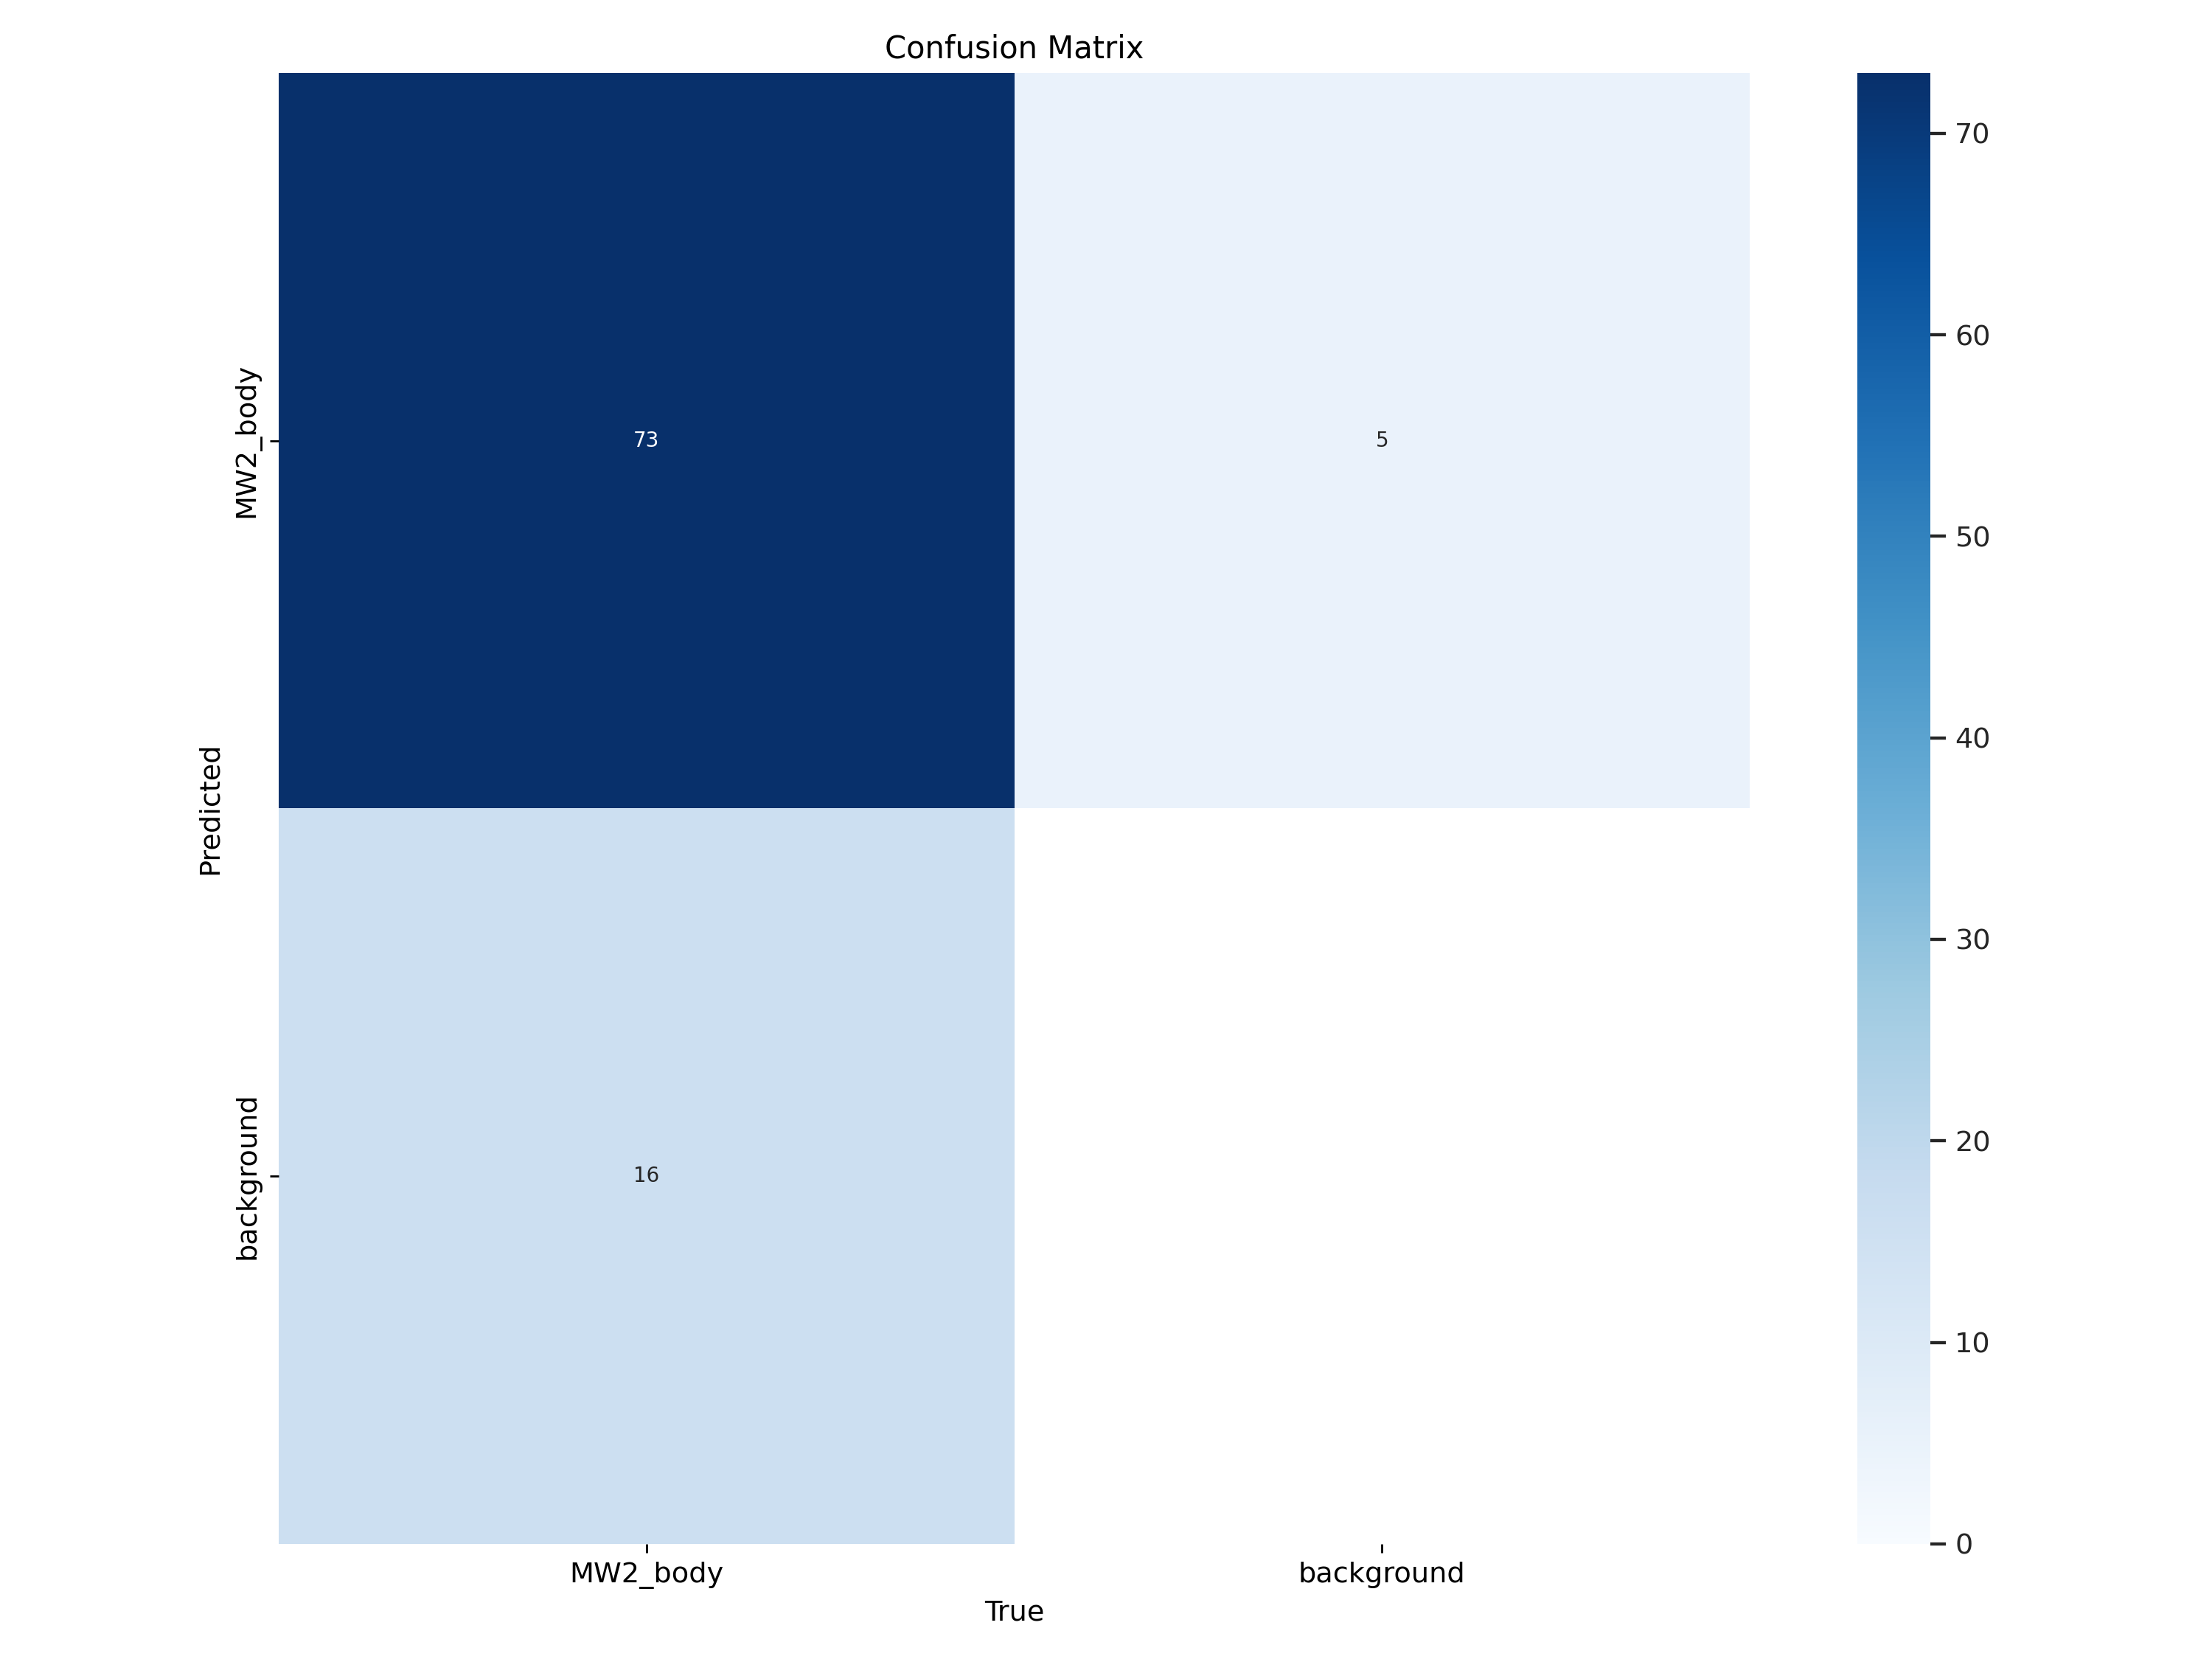

In [14]:
%cd {HOME}/datasets/Call-of-Duty-MW2-5/runs/detect/train/
Image(filename=f'confusion_matrix.png', width=600)

Above we can see that the model accurately predicted 73 MW2 bodies and falsely predicted 16 background objects as MW2 bodies and 5 MW2 bodies as background objects

/content/drive/MyDrive/Colab Notebooks/YOLO


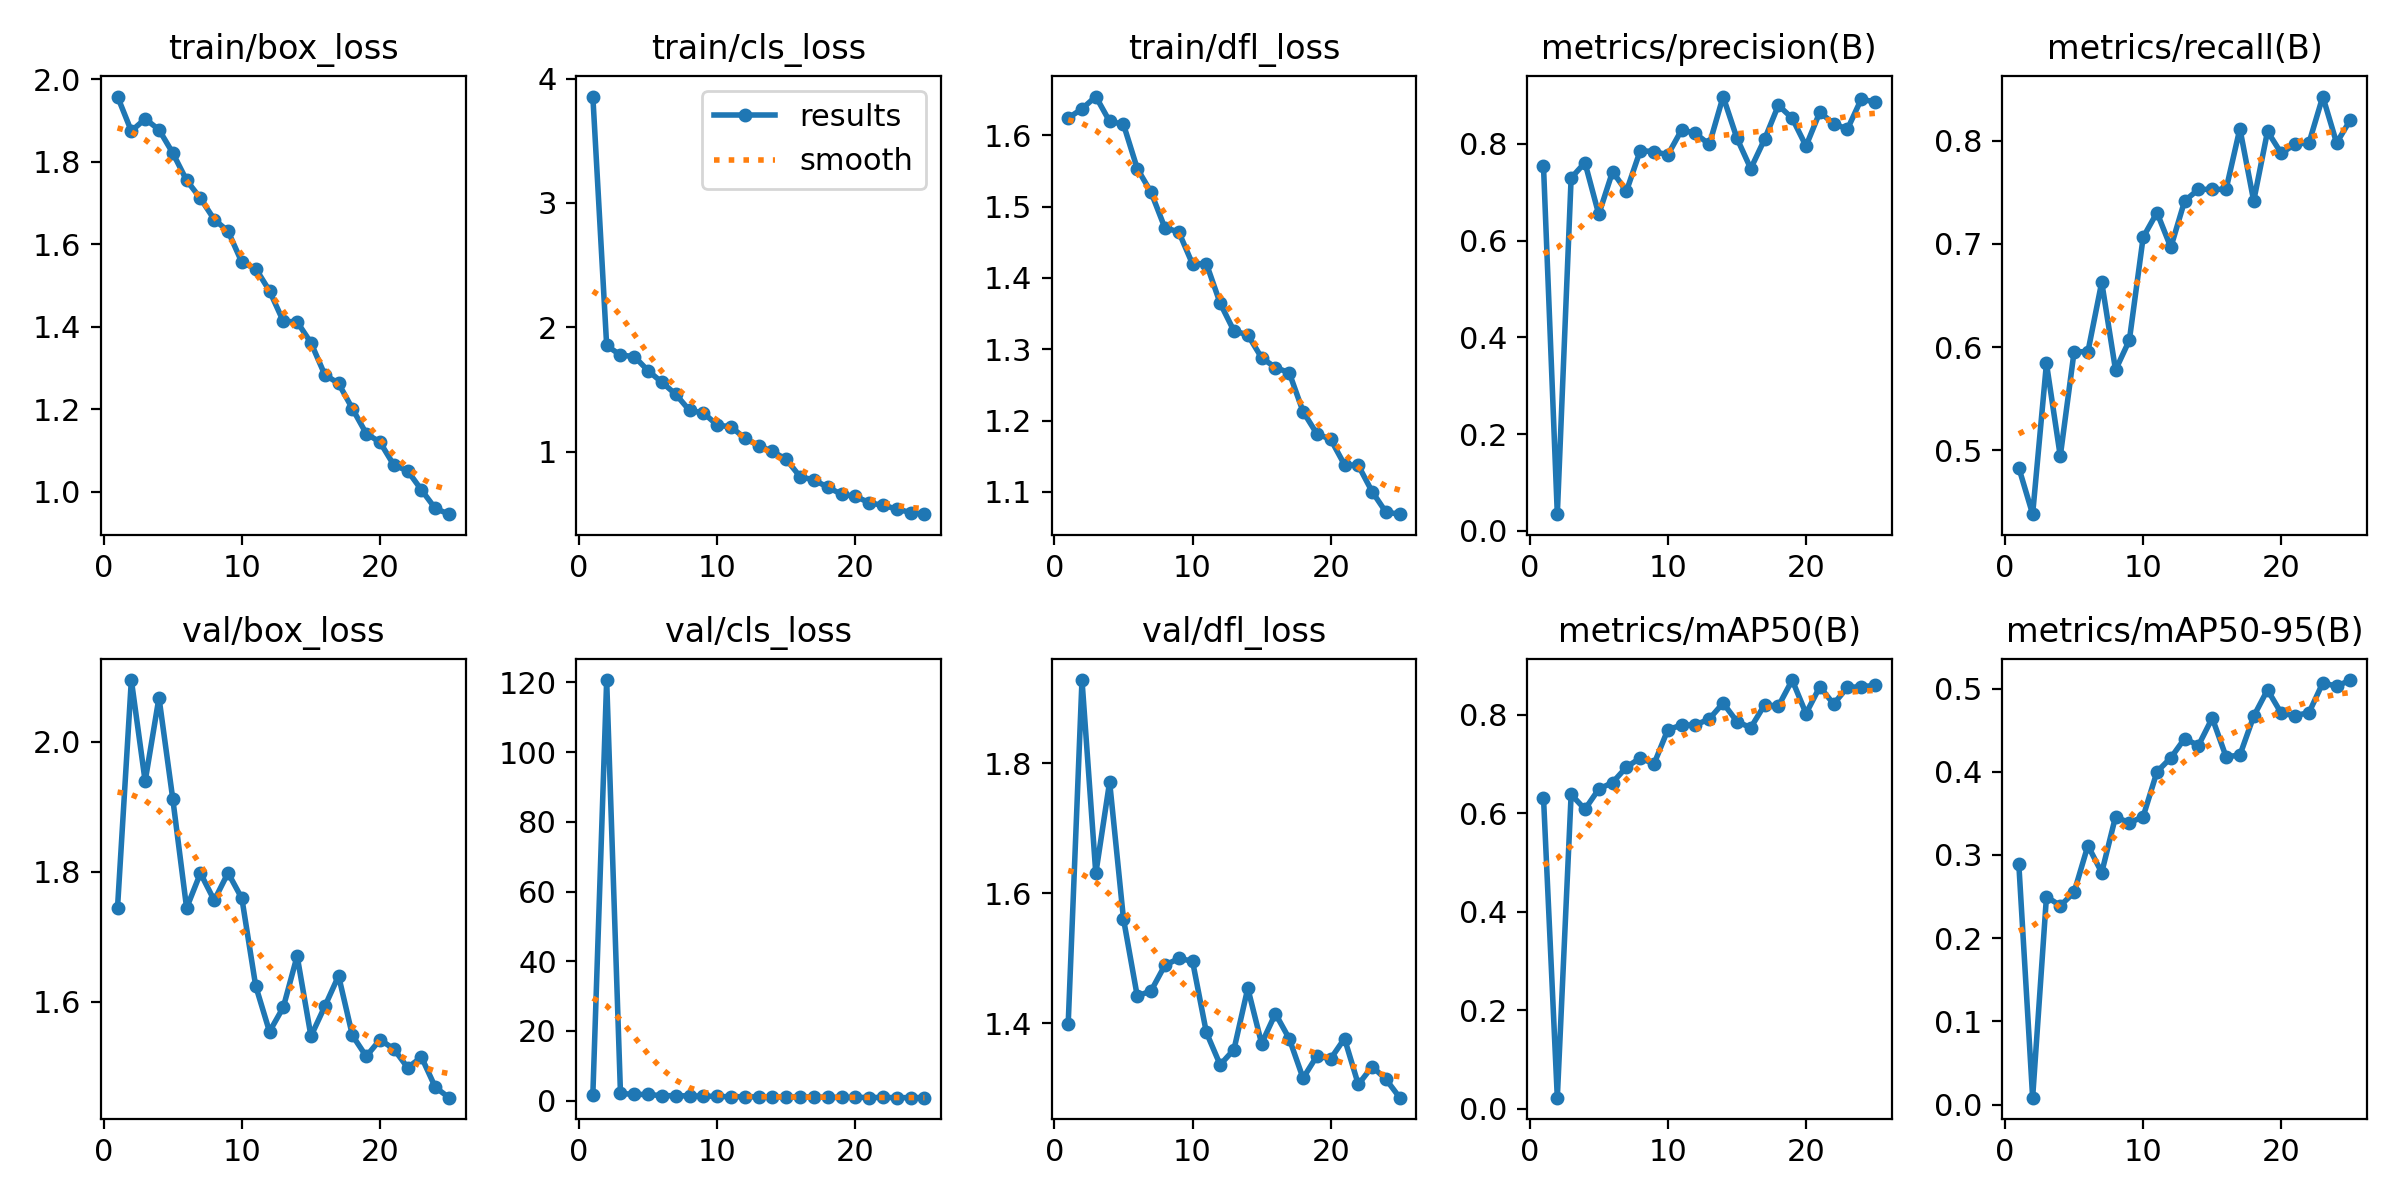

In [ ]:
#other results
# %cd {HOME}
# Image(filename=f'{HOME}/datasets/Call-of-Duty-MW2-5/runs/detect/train/results.png', width=600)

View a few results from training

/Users/vento/Coursework/CSCI 381/YOLO-Final-Project


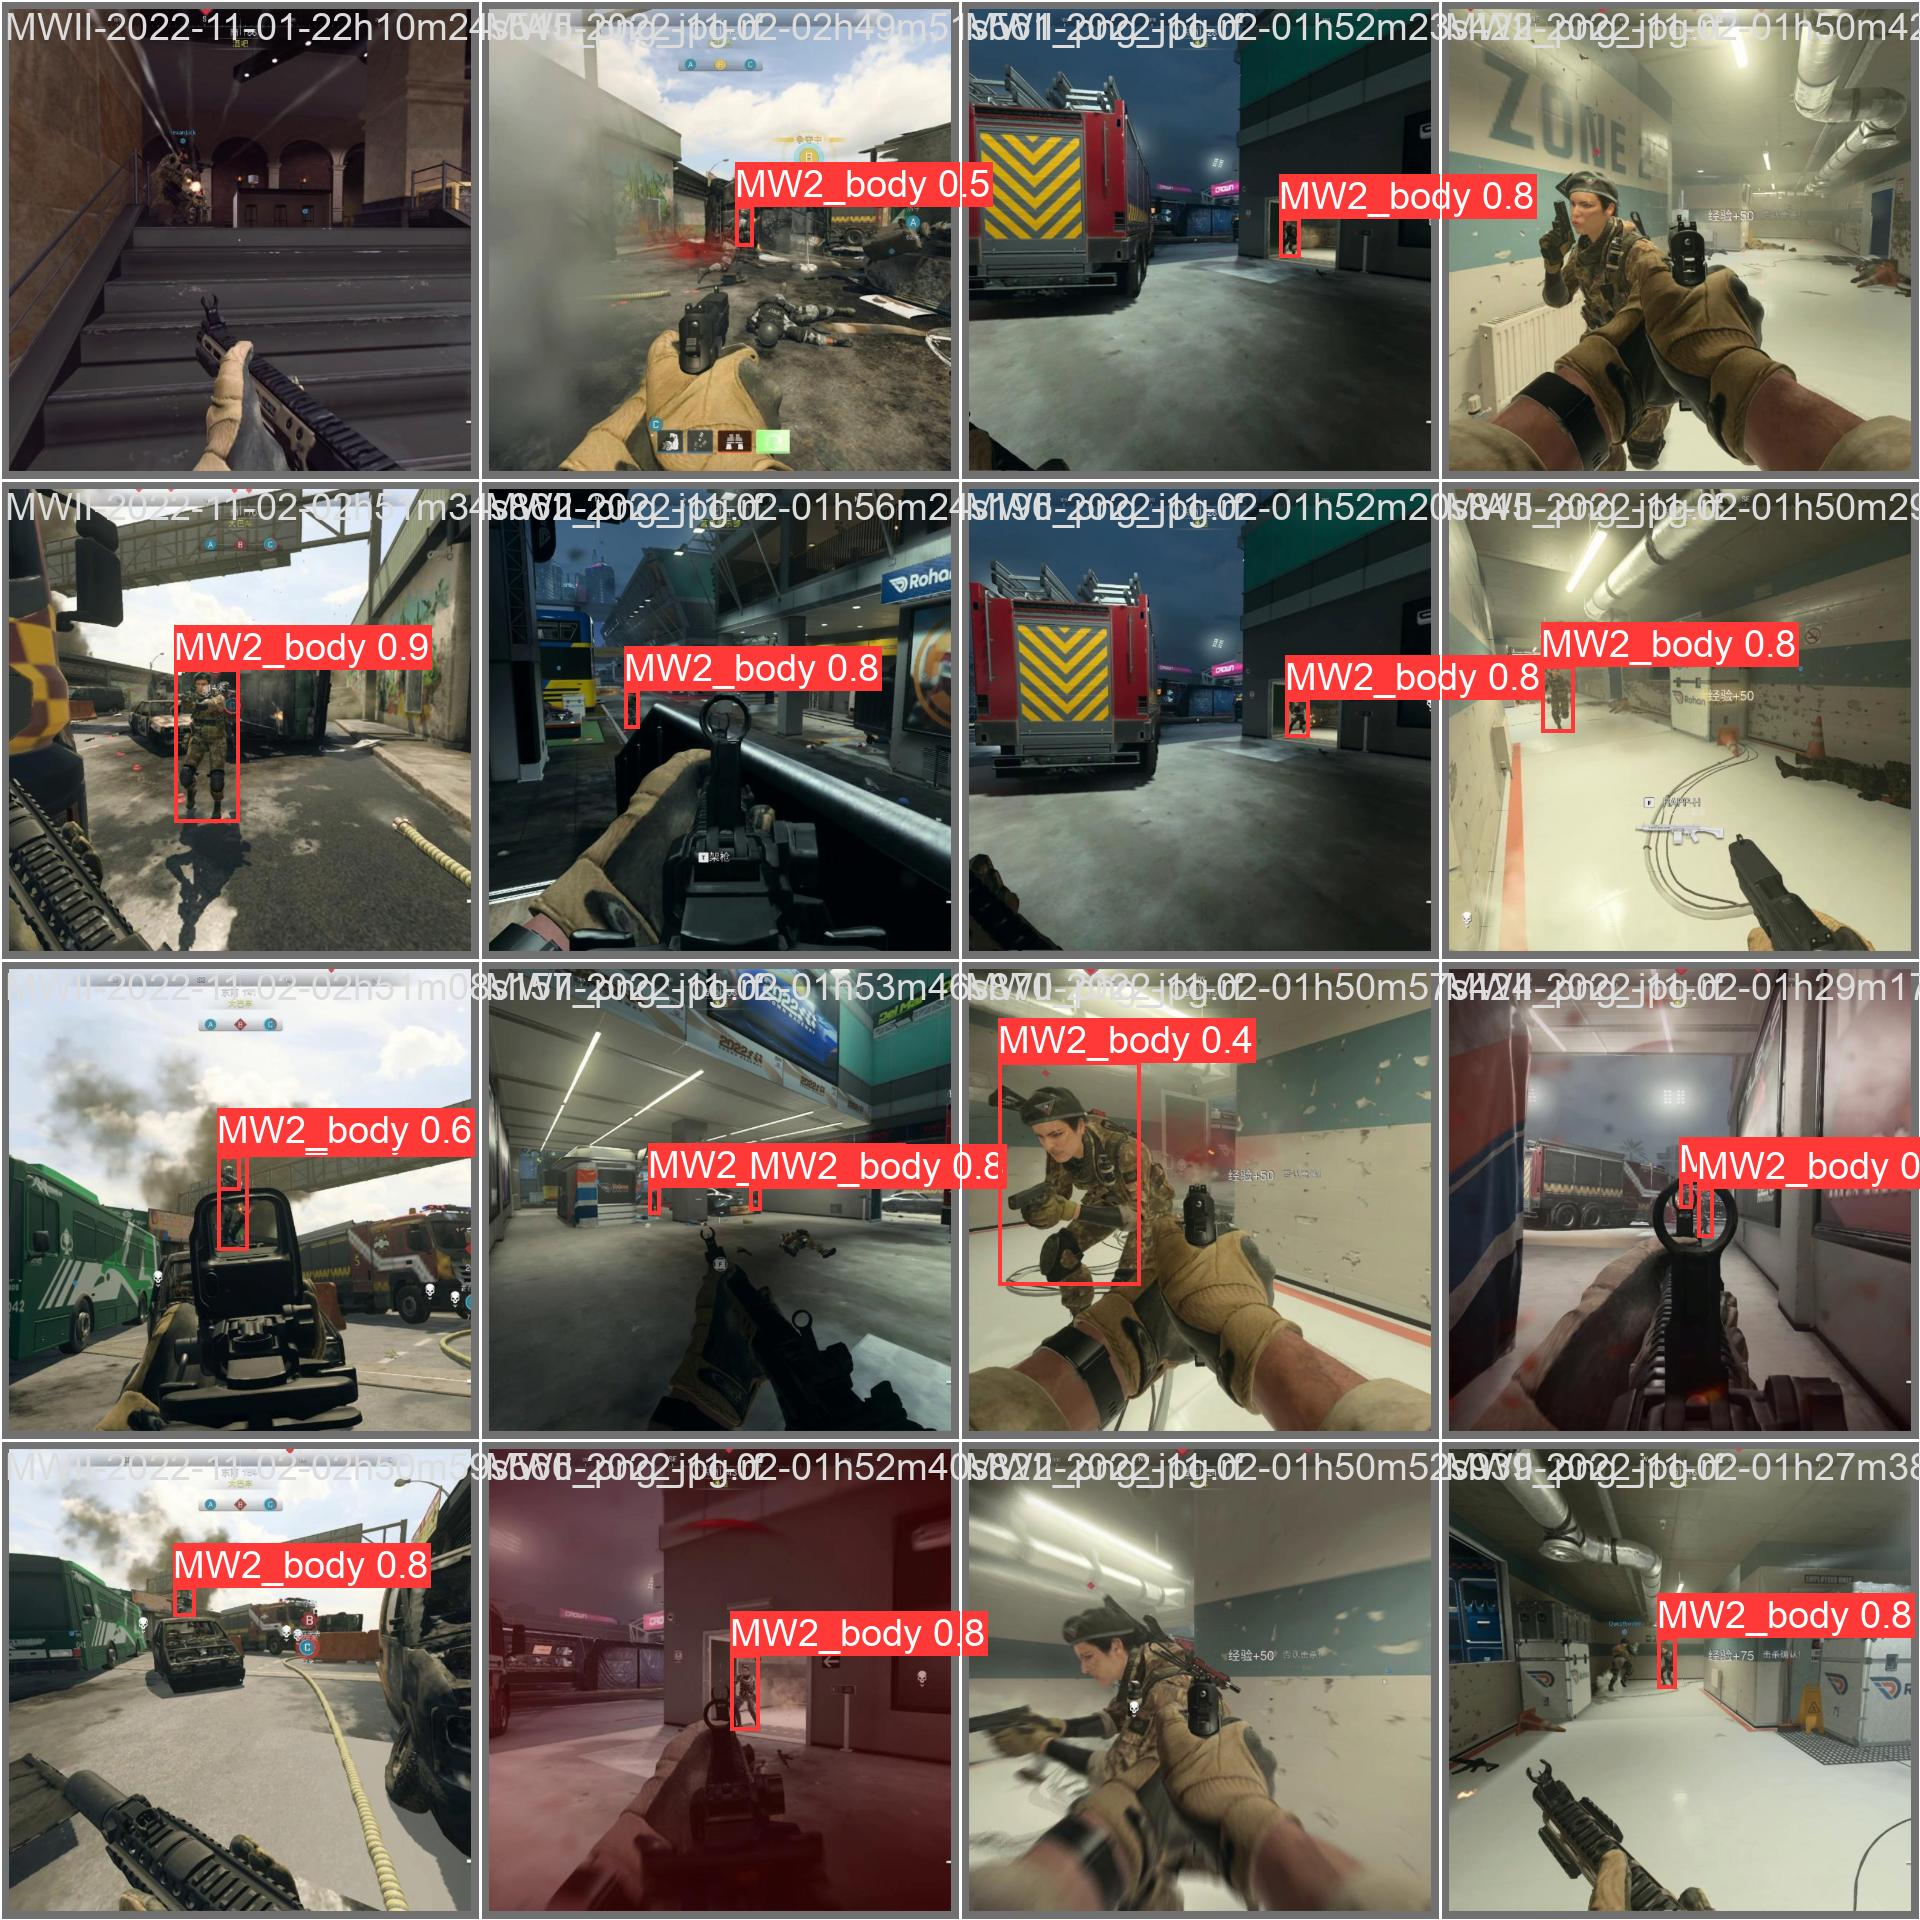

In [15]:
%cd {HOME}
Image(filename=f'{HOME}/datasets/Call-of-Duty-MW2-5/runs/detect/train/val_batch0_pred.jpg', width=600)

# Validate Custom Model

Validate the model using a separate dataset not used during training. Validation allows us to assess the model performance over data it was not trained on

In [21]:
%cd {HOME}/datasets/Call-of-Duty-MW2-5

!yolo task=detect mode=val model=./runs/detect/train/weights/best.pt data=data.yaml

/Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5
Ultralytics YOLOv8.2.4 🚀 Python-3.11.5 torch-2.2.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /Users/vento/Coursework/CSCI 381/YOLO-CS381-Final-Project/Call-of-
                 Class     Images  Instances      Box(P          R      mAP50  m^C


# Inference with Custom Model

Detect objects using our custom trained model with a confidence score of 0.25 and save the output. During inference, the YOLO model generates bounding boxes along with their associated confidence scores for each class. These bounding boxes are then filtered based on a predefined confidence threshold. Bounding boxes with confidence scores below the given threshold are discarded, while those above the threshold are considered valid detections.

In [22]:
#run inference on test images
%cd {HOME}/datasets/Call-of-Duty-MW2-5
!yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.25 source=test/images save=True

/Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5
Ultralytics YOLOv8.2.4 🚀 Python-3.11.5 torch-2.2.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

image 1/39 /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/test/images/MWII-2022-11-01-22h23m16s896_png_jpg.rf.f227e55683f72c0c2a7b3d60704b7624.jpg: 800x800 1 MW2_body, 247.6ms
image 2/39 /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/test/images/MWII-2022-11-01-22h27m46s414_png_jpg.rf.adb3187d44c07e259a681a769b4d33c8.jpg: 800x800 1 MW2_body, 224.4ms
image 3/39 /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/test/images/MWII-2022-11-01-22h29m15s188_png_jpg.rf.6a6a984fb47d164c9e09dc5aafdfaeb4.jpg: 800x800 1 MW2_body, 225.0ms
image 4/39 /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/test/images/MWII-2022-11-01-22h29m17s978_png_jpg.rf.dc

In [26]:
# %cd {HOME}/datasets/Call-of-Duty-MW2-5
# !yolo task=detect mode=predict model=runs/detect/train/weights/best.pt conf=0.25 source='./videos/CoD2.mov' save=True

/Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5


using dhist requires you to install the `pickleshare` library.


Ultralytics YOLOv8.2.4 🚀 Python-3.11.5 torch-2.2.0 CPU (Apple M2)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

video 1/1 (frame 1/2263) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/videos/CoD2.mov: 448x800 (no detections), 144.0ms
video 1/1 (frame 2/2263) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/videos/CoD2.mov: 448x800 (no detections), 151.0ms
video 1/1 (frame 3/2263) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/videos/CoD2.mov: 448x800 (no detections), 131.2ms
video 1/1 (frame 4/2263) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/videos/CoD2.mov: 448x800 (no detections), 119.1ms
video 1/1 (frame 5/2263) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/datasets/Call-of-Duty-MW2-5/videos/CoD2.mov: 448x800 (no detections), 121.1ms
video 1/1 (frame 6/2263) /Users/vento/Coursework/CSCI 381/YOLO-Final-Project/

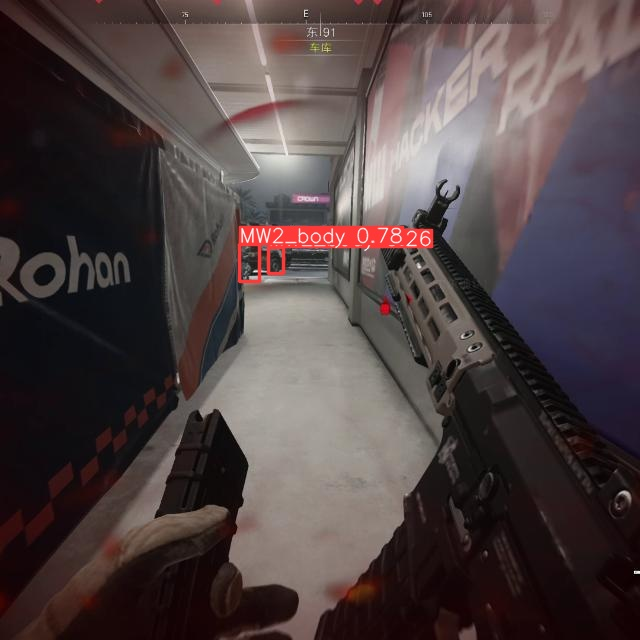

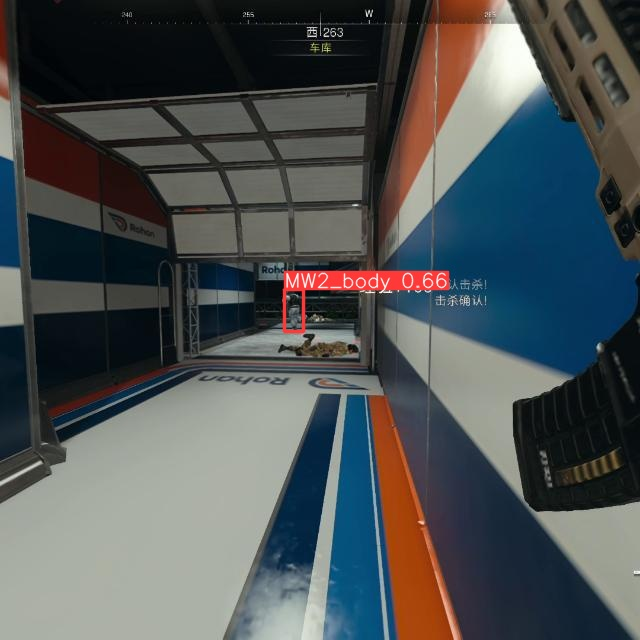

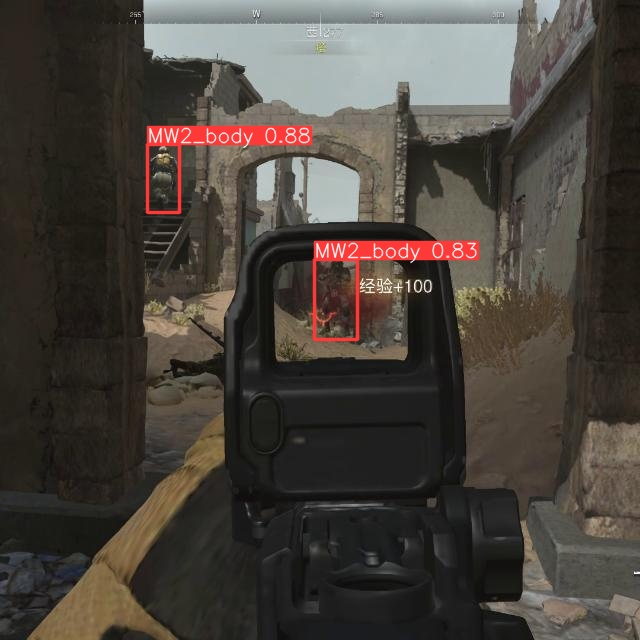

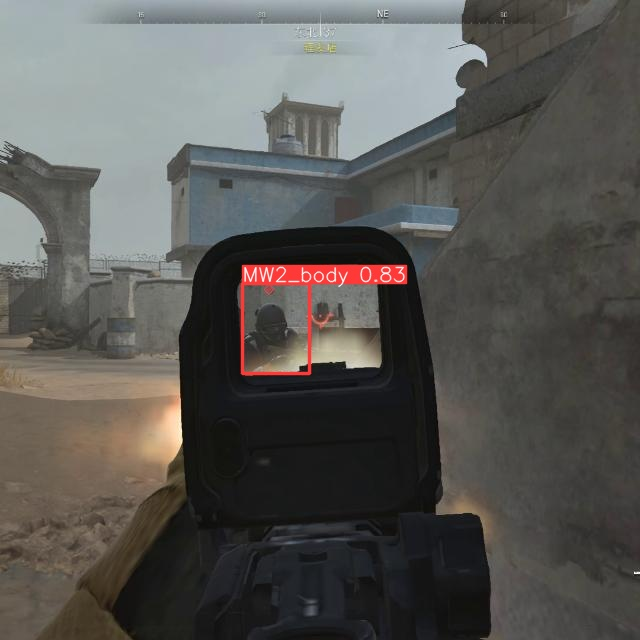

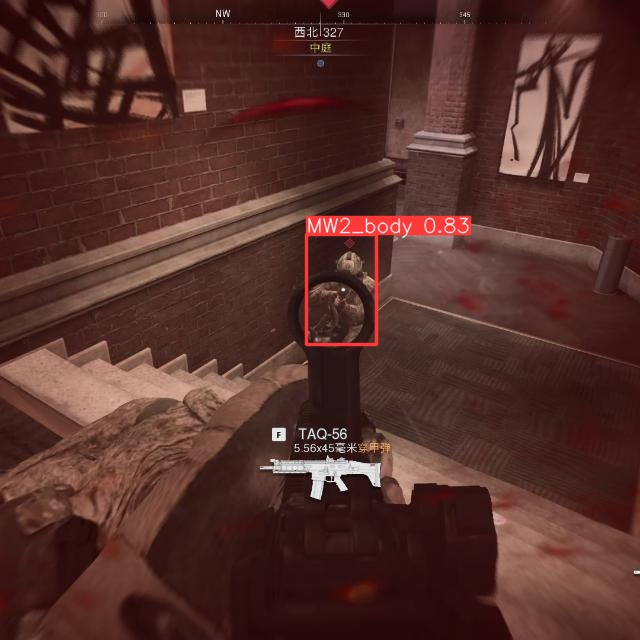

In [28]:
#Checking a few results:

import glob

for image_path in glob.glob(f'{HOME}/datasets/Call-of-Duty-MW2-5/runs/detect/predict/*.jpg')[:5]:
      display(Image(filename=image_path, width=600))
      print("\n")